# Aparent2-GTEx results

Explore Enformer predictions on GTEx variants

## Setup

In [9]:
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotnine as pn
from scipy.stats import ranksums
from datetime import datetime

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
plt.rcParams['figure.dpi'] = 150

In [11]:
pl.Config.set_fmt_str_lengths(100)

polars.config.Config

In [12]:
pn.theme_set(pn.theme_bw())
pn.theme_update(dpi=150)

In [13]:
# Files relevant to the GTEx analysis
run_name = 'aparent2_ensembl_deltapdui_wide'
# enformer variant effect on GTEx variants
aparent2_path = f'/s/project/promoter_prediction/kipoi_expression_prediction/veff/aparent2.parquet/run={run_name}'
# GTEx variants
variant_path = '/s/project/rep/processed/training_results_v15/gtex_v8_old_dna/private_variants.parquet/rare_variants.vcf.parquet/**/*.parquet'
# abexp benchmark dataset
gtex_benchmark_with_annotation_path = "/s/project/rep/processed/training_results_v15/gtex_benchmark_with_annotation.parquet/*.parquet"

## Analysis

We are only loading ensembl canonical transcripts for this analysis. So there is 1 transcript per gene!

In [14]:
veff_transcript_ldf = (pl.scan_parquet(Path(aparent2_path) / '*.parquet').
                       select(pl.col(['tissue', 'gene_id', 'transcript_id', 'pas_id', 'cse_pos', 'pas_pos',]), 
                              pl.col('strand').cast(pl.Enum(['-', '+'])),
                              pl.col(['chrom', 'variant_start', 'variant_end', 'ref', 'alt', 'veff_score', 'ref_score', 'alt_score'])).
                       rename({'gene_id': 'gene', 'transcript_id': 'transcript'}).
                       with_columns(pl.col('gene').str.replace(r'([^\.]+)\..+$', "${1}").alias('gene'),
                                    pl.col('transcript').str.replace(r'([^\.]+)\..+$', "${1}").alias('transcript')))


# It is possible that a gene comes multiple times (different versions)

In [20]:
variant_ldf = pl.scan_parquet(variant_path, hive_partitioning=True).select(['sampleId', 'chrom', 'start', 'end', 'ref', 'alt']).rename({'sampleId': 'individual',
                                                                                                                'start': 'variant_start',
                                                                                                                'end': 'variant_end'})

In [21]:
training_benchmark_ldf = (pl.scan_parquet(gtex_benchmark_with_annotation_path)
                          .select(['gene', 'individual', 'tissue', 'FDR', 
                                   'mu', 'zscore', 'l2fc', 'is_obvious_outlier'])
                          .unique()
                          .rename({'l2fc': 'l2fc_outrider'})
                          .with_columns((pl.when(pl.col('FDR') > 0.2)
                                         .then(pl.lit('normal'))
                                         .otherwise(
                                             pl.when(pl.col('zscore') > 0)
                                             .then(pl.lit('overexpressed'))
                                             .otherwise(
                                                 pl.when(pl.col('zscore') < 0)
                                                 .then(pl.lit('underexpressed'))
                                                 # this should never be the case
                                                 .otherwise(pl.lit('CHECK'))
                                             ))).cast(pl.Enum(['underexpressed', 'normal', 'overexpressed'])).alias('outlier_state')))

### What is the enformer variant-effect-score distribution around the TSS?

In [53]:
upstream=70
downstream=130

# join variants with enformer_veff on veff
veff_variant_ldf = variant_ldf.join(veff_transcript_ldf, how='inner', on=['chrom', 'variant_start', 'variant_end', 'ref', 'alt'])
# calculate variant position relative to the tss: rel_var_pos
veff_variant_ldf = veff_variant_ldf.with_columns((pl.when(pl.col('strand') == '+')
                                 .then(pl.col('variant_start') - pl.col('cse_pos'))
                                 .otherwise(pl.col('cse_pos') - pl.col('variant_start'))
                            ).alias('rel_var_pos'))
# filter out variants far from the CSE
veff_variant_ldf = veff_variant_ldf.filter((pl.col('rel_var_pos') >= -upstream) & (pl.col('rel_var_pos') < downstream))
veff_variant_ldf = (veff_variant_ldf.
                              select(['individual', 'chrom', 'variant_start', 'variant_end', 'ref', 'alt', 'tissue', 'gene',
                                      'transcript', 'pas_id', 'strand', 'veff_score', 'ref_score', 'alt_score', 'rel_var_pos']))

# join outrider with variants on individual
veff_outrider_ldf = (veff_variant_ldf.join(training_benchmark_ldf, how='inner', on=['individual', 'gene', 'tissue']).
                               select(['gene', 'tissue', 'individual', 'rel_var_pos', 'outlier_state', 'zscore', 'FDR', 'veff_score',
                                       'l2fc_outrider', 'mu', 'is_obvious_outlier'])) 

In [54]:
# pl.Config.set_streaming_chunk_size(100)
# print(veff_outrider_ldf.explain(streaming=True))

In [55]:
veff_outrider_df = veff_outrider_ldf.collect(streaming=True)

In [56]:
# rel_var_pos in bins
bin_size=10
cuts = list(range(-upstream + bin_size, downstream, bin_size))
cut_labels = [str(x) for x in [-upstream, *cuts]]
# cut_labels = [f'[-{upstream}, -{upstream - bin_size})'] + [f'[{cuts[i]}, {cuts[i+1]})' for i in range(len(cuts) - 1)] + [f'[{downstream - bin_size}, {downstream})']
veff_outrider_df = (veff_outrider_df.with_columns(
    (pl.col('rel_var_pos').cut(cuts, labels=cut_labels)).alias('rel_var_pos_bin').cast(pl.Enum(cut_labels))
).with_columns((pl.col('outlier_state') == 'underexpressed').alias('is_underexpressed')))

veff_outrider_df = veff_outrider_df.with_columns(rel_var_pos_bin_label = pl.col("rel_var_pos_bin").cast(pl.String), bin_size=pl.lit(50))
for c in cut_labels:
    veff_outrider_df = veff_outrider_df.with_columns(rel_var_pos_bin_label = pl.col("rel_var_pos_bin_label")
                                                     .replace(str(c), f'[{c}, {int(c) + bin_size})'))

In [70]:
# set new bins
# new_bins = [(-2000, -500),
#             *[(i, i + 100) for i in range(-500, -100, 100)],
#             (-100, -50),
#             (-50, 0),
#             (0, 50),
#             (50, 100),
#             *[(i, i + 100) for i in range(100, 500, 100)],]
new_bins = [(x, x + 10) for x in range(-70, 130, 10)]
new_bin_labels  = [f'[{start}, {stop})' for start, stop in new_bins]

for idx, interval_ in enumerate(new_bins):
    start, stop = interval_
    veff_outrider_df = veff_outrider_df.with_columns(
        rel_var_pos_bin_label = pl.when((pl.col('rel_var_pos_bin').cast(pl.Int16) >= start) & (pl.col('rel_var_pos_bin').cast(pl.Int16) < stop))
                                  .then(pl.lit(new_bin_labels[idx]))
                                  .otherwise(pl.col('rel_var_pos_bin_label')),
        bin_size = pl.when((pl.col('rel_var_pos_bin').cast(pl.Int16) >= start) & (pl.col('rel_var_pos_bin').cast(pl.Int16) < stop))
                                  .then(pl.lit(stop - start))
                                  .otherwise(pl.col('bin_size')))
veff_outrider_df = veff_outrider_df.with_columns(rel_var_pos_bin_label=pl.col('rel_var_pos_bin_label').cast(pl.Enum(new_bin_labels)))

In [58]:
# calculate counts per bins
bin_count_df = veff_outrider_df.group_by(['outlier_state', 'rel_var_pos_bin_label', 'bin_size']). \
    agg((pl.len()).alias('count'))

# # calculate mean of each bin and then sum the means in each outlier state
totals_df = bin_count_df.group_by('outlier_state').agg(pl.sum('count').alias('total_count'))
# # normalize each count by the mean calculated above
enrichment_df = bin_count_df.join(totals_df, on='outlier_state').with_columns((pl.col('count') / pl.col('total_count')).alias('enrichment'))
ci_low, ci_high = sm.stats.proportion_confint(enrichment_df["count"], enrichment_df["total_count"])
enrichment_df = enrichment_df.with_columns(pl.Series(ci_low).alias('ci_low'), pl.Series(ci_high).alias('ci_high'))
# normalize by bin size
enrichment_df = enrichment_df.with_columns(enrichment = pl.col('enrichment') / pl.col('bin_size'),
                                           ci_low = pl.col('ci_low') / pl.col('bin_size'),
                                           ci_high = pl.col('ci_high') / pl.col('bin_size'))

In [59]:
score_column = 'veff_score'

In [60]:
enrichment_df.head()

outlier_state,rel_var_pos_bin_label,bin_size,count,total_count,enrichment,ci_low,ci_high
enum,enum,i32,u32,u32,f64,f64,f64
"""normal""","""[80, 90)""",10,61182,1236604,0.004948,0.004909,0.004986
"""normal""","""[-40, -30)""",10,63563,1236604,0.00514,0.005101,0.005179
"""overexpressed""","""[-40, -30)""",10,36,546,0.006593,0.004512,0.008675
"""underexpressed""","""[-60, -50)""",10,24,1392,0.001724,0.00104,0.002408
"""normal""","""[70, 80)""",10,62411,1236604,0.005047,0.005008,0.005086


In [61]:
totals_df

outlier_state,total_count
enum,u32
"""normal""",1236604
"""overexpressed""",546
"""underexpressed""",1392


In [47]:
veff_outrider_df.filter((pl.col('rel_var_pos') > -20) & (pl.col('rel_var_pos') < 20)).select(['gene', 'individual', 'outlier_state', 'tissue']).unique(). \
    group_by(pl.col('outlier_state')).agg(pl.len())

outlier_state,len
enum,u32
"""normal""",229611
"""underexpressed""",467
"""overexpressed""",103


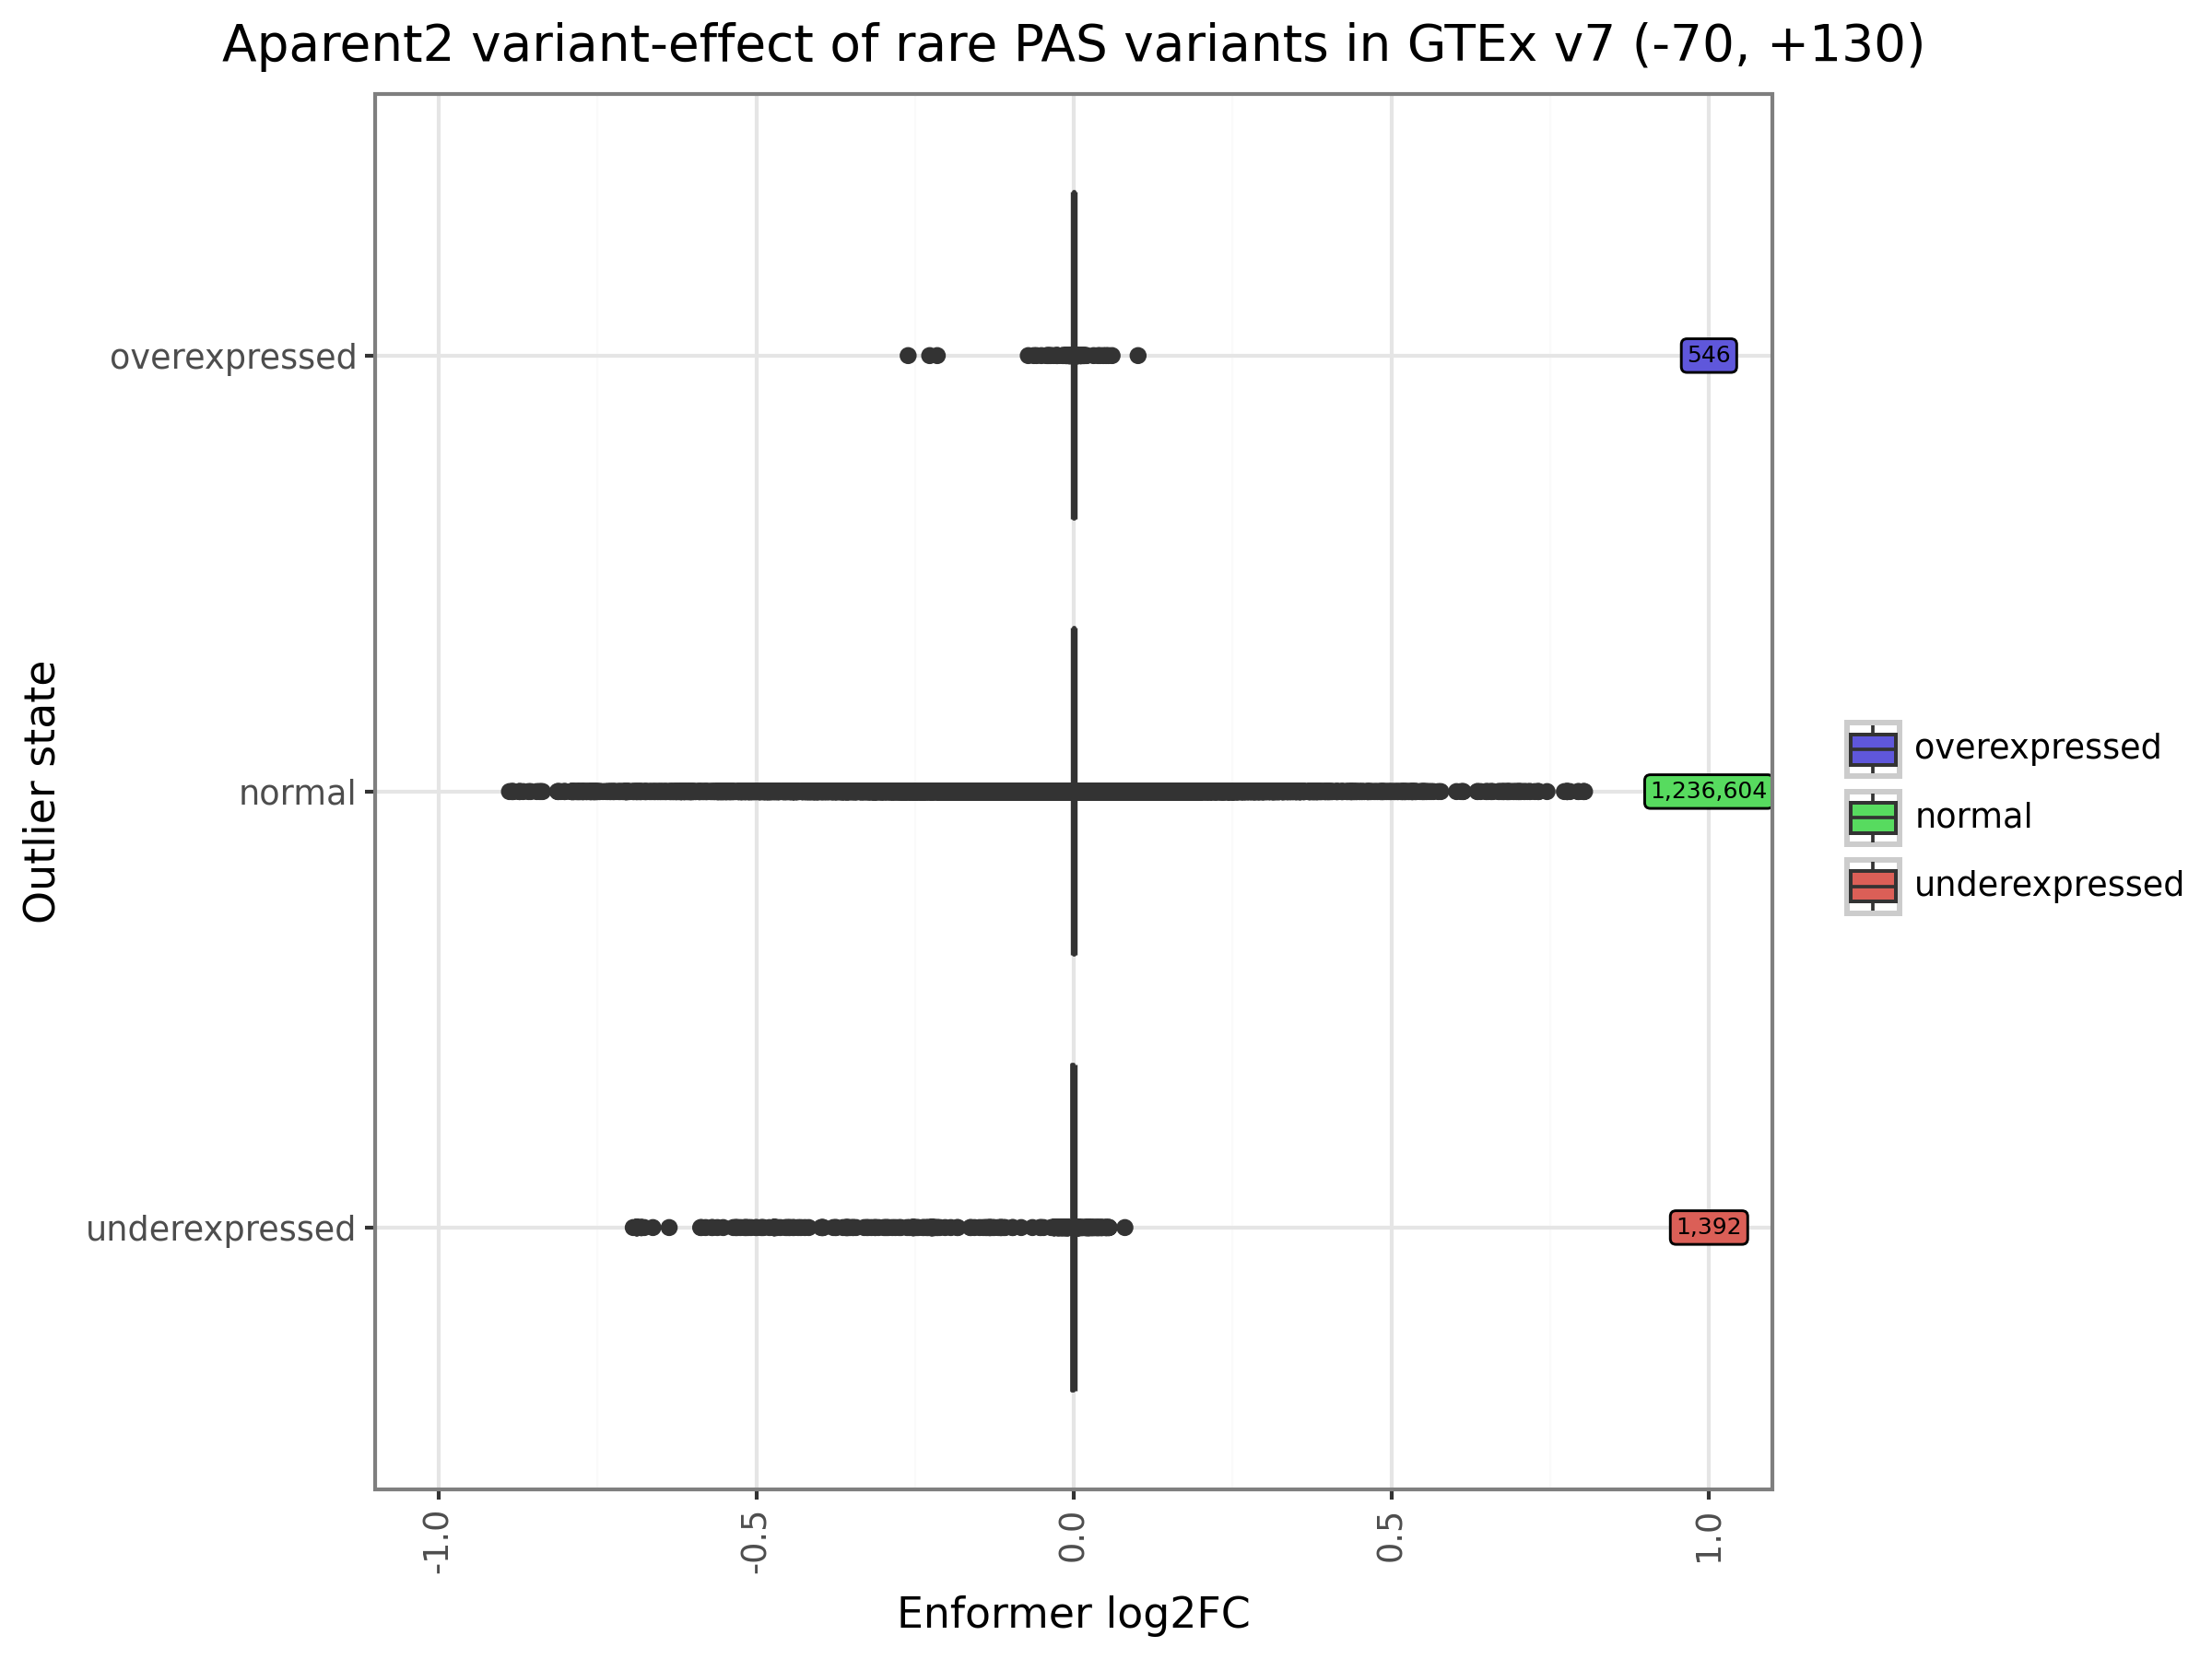

In [62]:
cnt = veff_outrider_df.group_by(['outlier_state']).len().with_columns(
        (pl.col("len").map_elements(lambda x: format(x, ','), str))
    )
p1 = (
        pn.ggplot(veff_outrider_df, pn.aes(x="outlier_state", fill="outlier_state"))
        + pn.geom_boxplot(pn.aes(y=score_column))
        + pn.theme(
            figure_size=(8, 6),
            axis_text_x=pn.element_text(angle=90),
            dpi=150
        )
        + pn.labs(
            x="Outlier state", 
            y="Enformer log2FC",
            color="",
            fill="",
            title=f"Aparent2 variant-effect of rare PAS variants in GTEx v7 (-{upstream}, +{downstream})",
        )
        + pn.guides(size='none', fill = pn.guide_legend(reverse = True))
        + pn.geom_label(cnt, pn.aes(label='len', y=1, size=8), show_legend=False)
        + pn.coord_flip(ylim=[-1, 1])
    )
p1

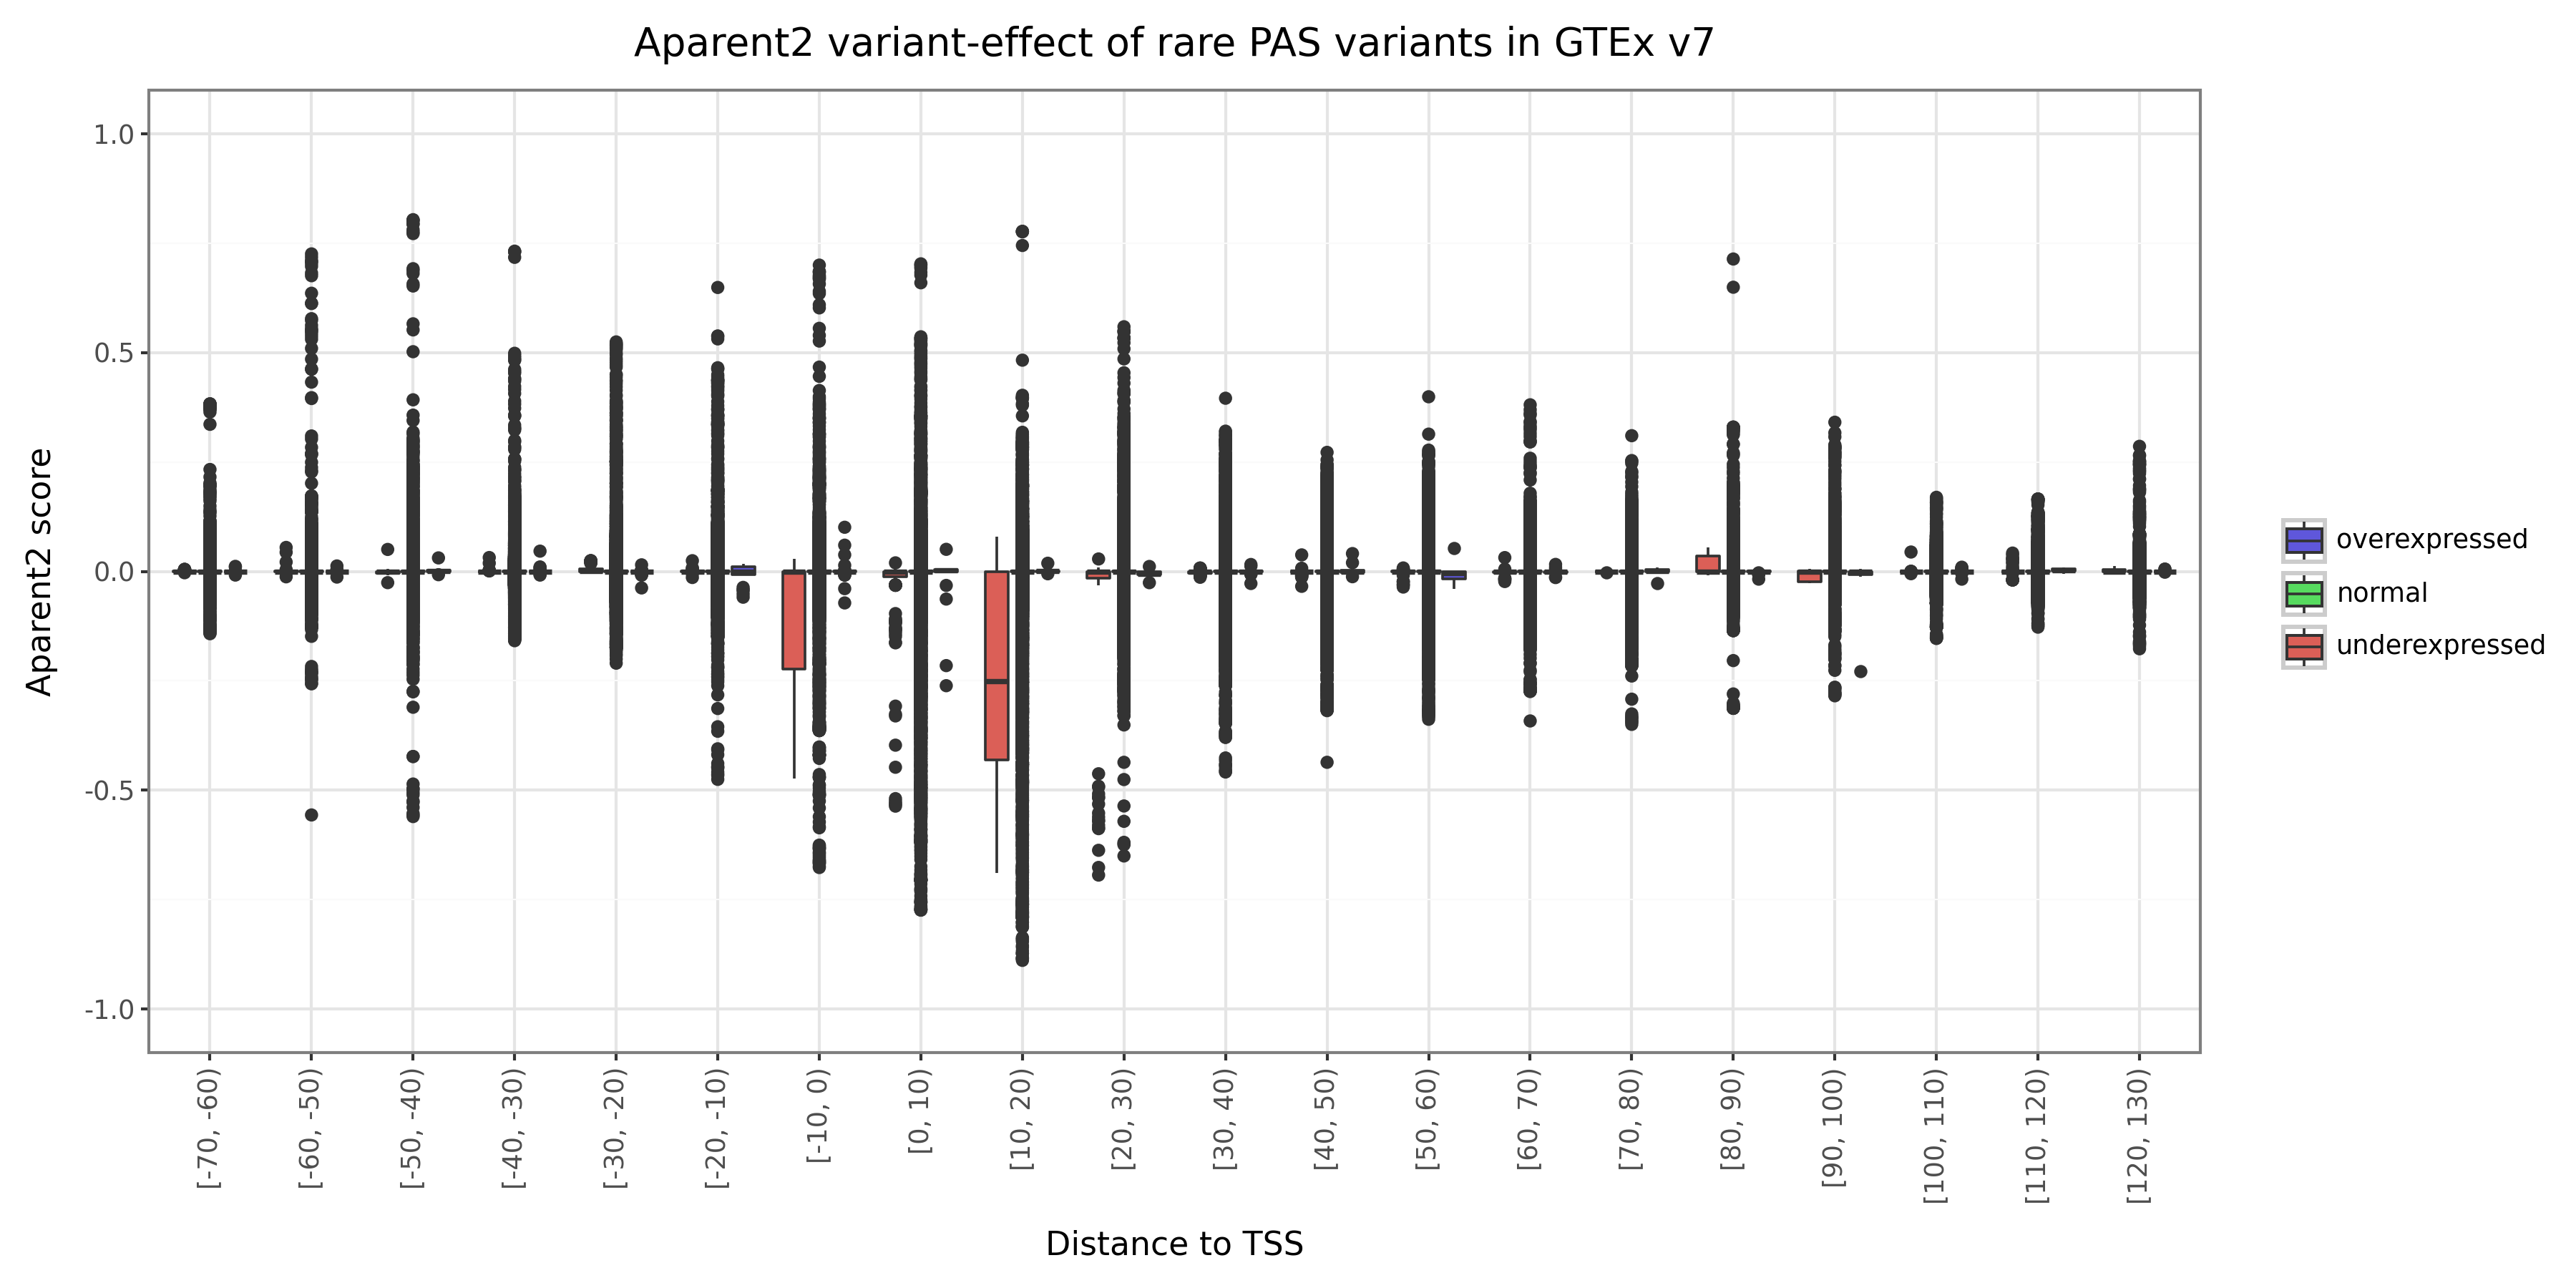

In [66]:
p2 = (
        pn.ggplot(veff_outrider_df, pn.aes(x="rel_var_pos_bin_label", fill="outlier_state"))
        + pn.geom_boxplot(pn.aes(y=score_column))
        + pn.theme(
            figure_size=(12, 6),
            axis_text_x=pn.element_text(angle=90),
            dpi=150
        )
        + pn.labs(
            x="Distance to TSS", 
            y="Aparent2 score",
            color="",
            fill="",
            title="Aparent2 variant-effect of rare PAS variants in GTEx v7",
        )
        + pn.coord_cartesian(ylim=[-1, 1])
        + pn.guides(size='none', fill = pn.guide_legend(reverse = True))
    )
p2

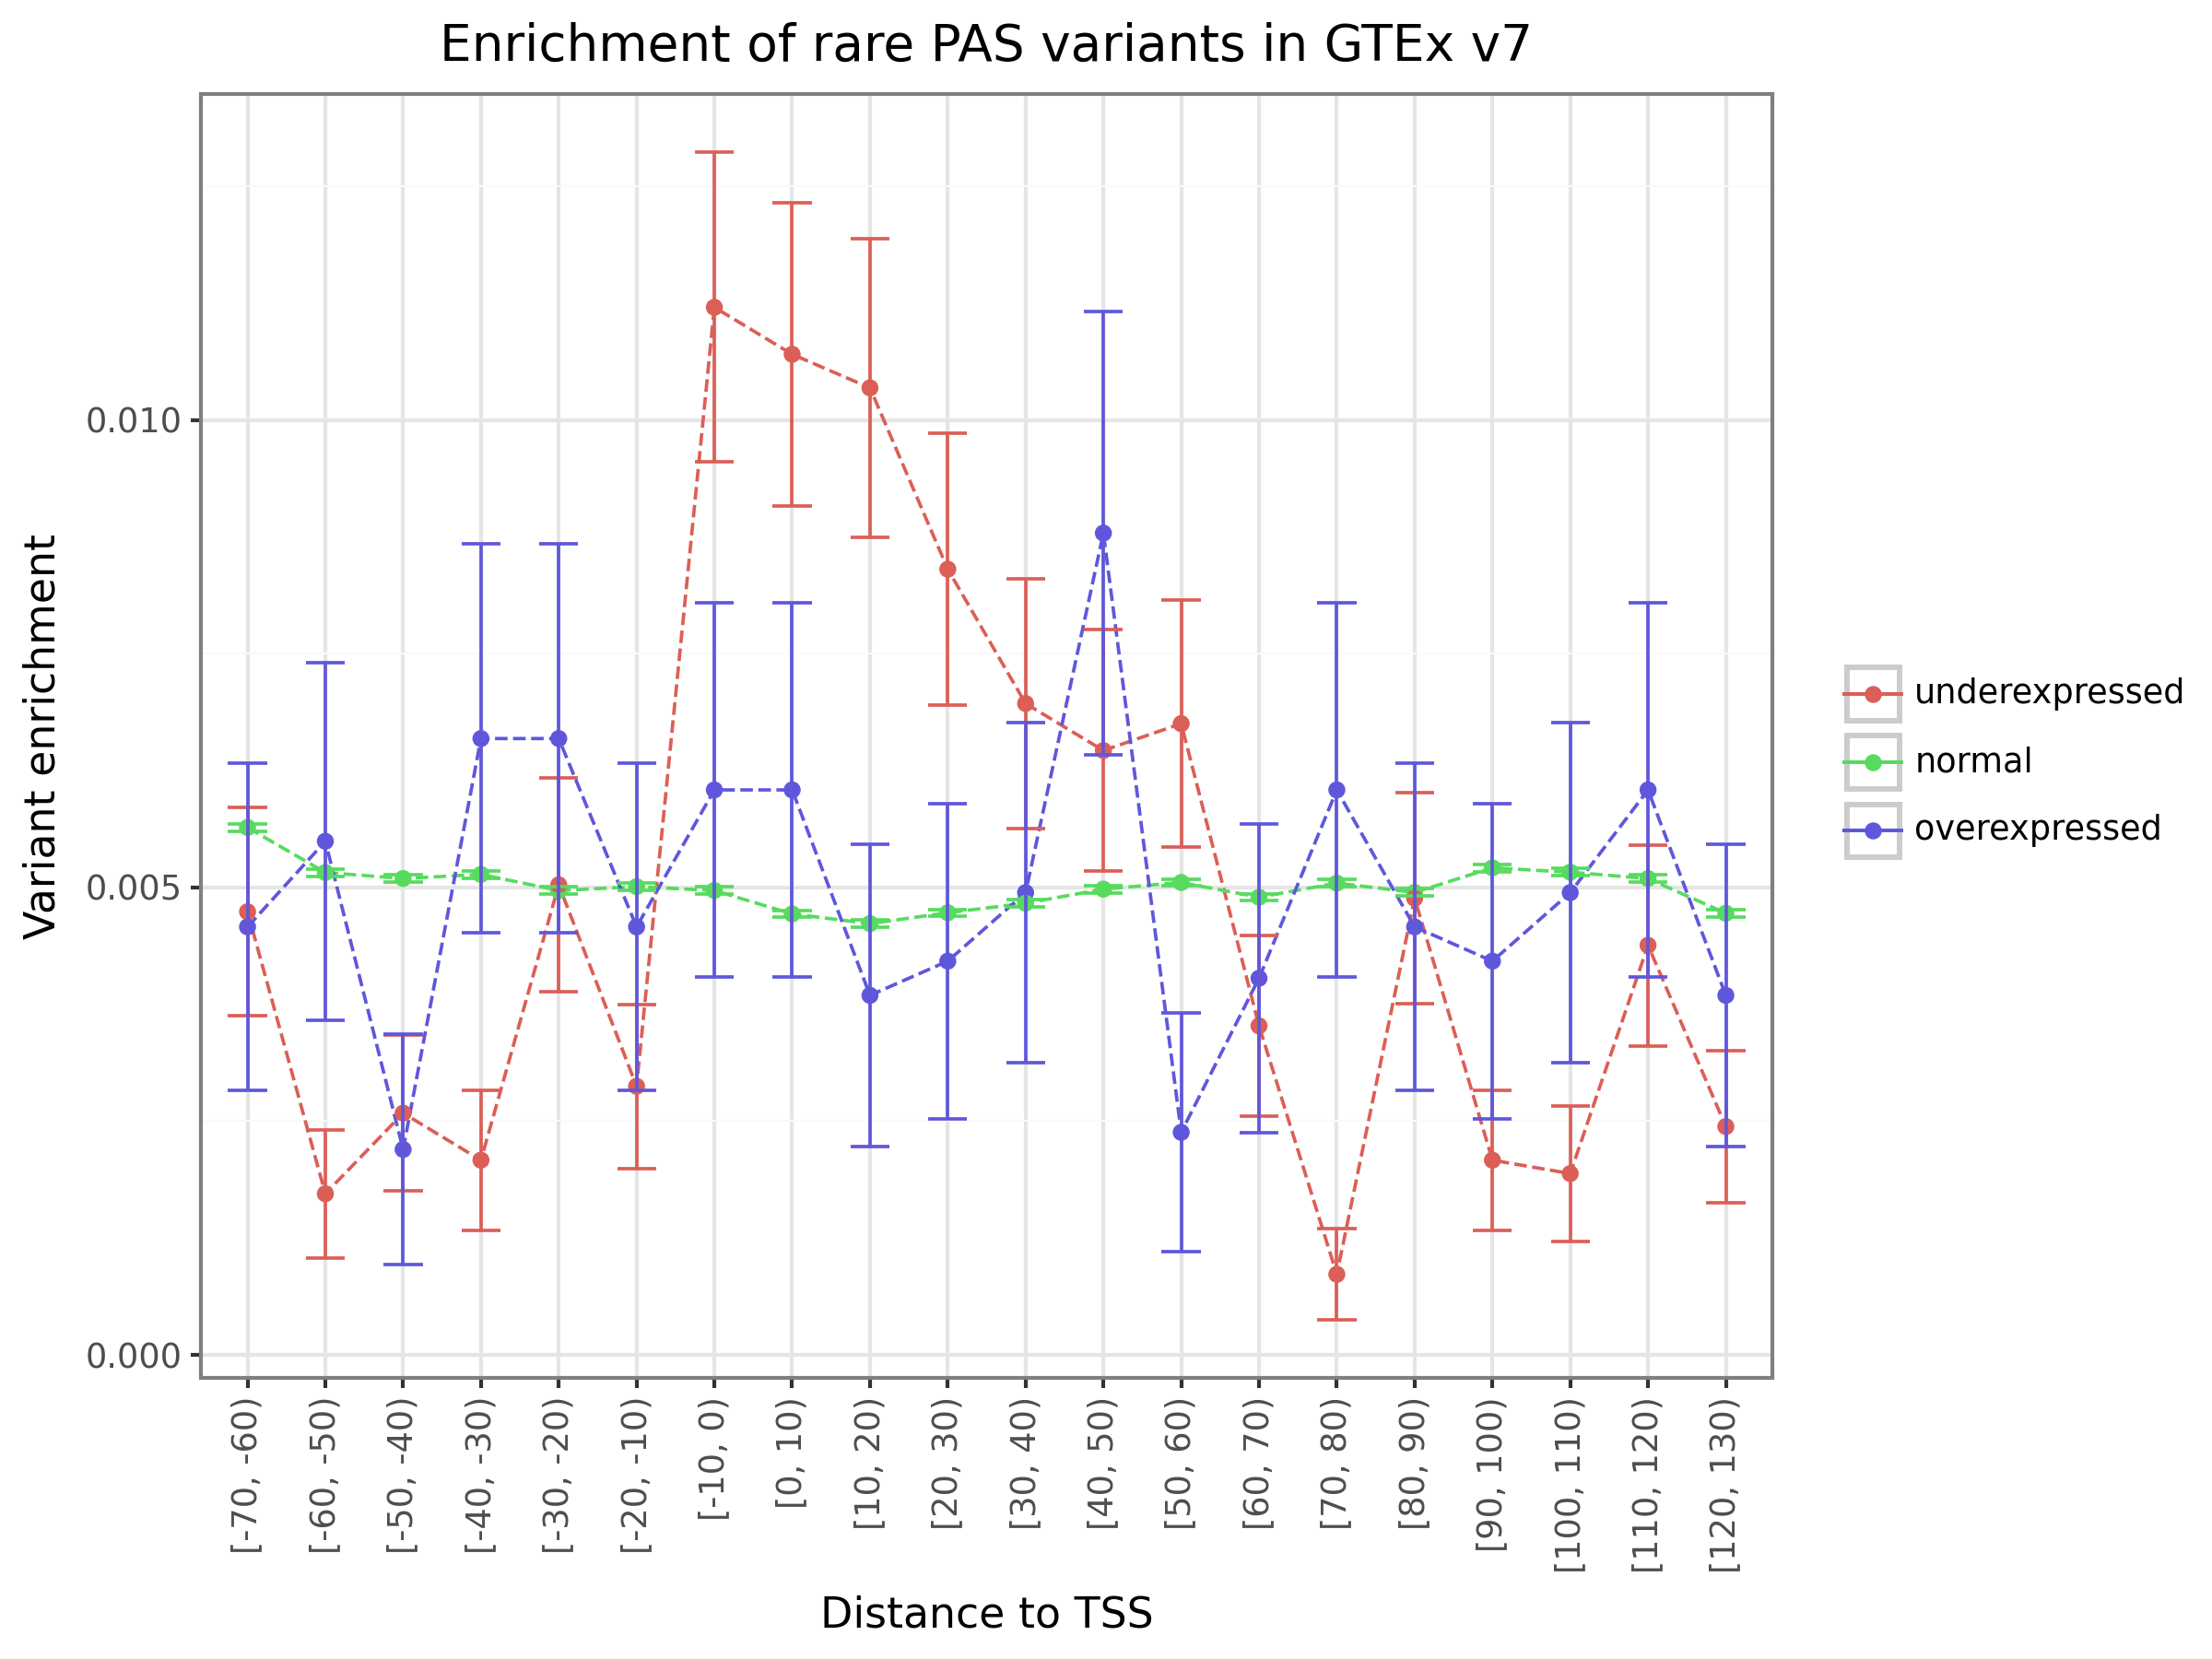

In [67]:
p3 = (
    pn.ggplot(enrichment_df, pn.aes(x="rel_var_pos_bin_label", y="enrichment", fill="outlier_state", color="outlier_state"))
    + pn.geom_line(pn.aes(group="outlier_state"), linetype="dashed")
    + pn.geom_point()
    + pn.geom_errorbar(pn.aes(ymin="ci_low", ymax="ci_high"))
    + pn.theme(
        figure_size=(8, 6),
        axis_text_x=pn.element_text(angle=90),
        dpi=150
    )
    + pn.labs(
        x="Distance to TSS", 
        y="Variant enrichment",
        color="",
        fill="",
        title="Enrichment of rare PAS variants in GTEx v7",
    )
)
p3

In [40]:
base_path = Path('/data/nasif12/home_if12/tsi/kipoi_expression_prediction/etc/aparent2_bins') / datetime.now().strftime("%Y%m%d%H%M")
base_path.mkdir(parents=True)
veff_outrider_df.write_parquet(base_path / 'veff_bin.parquet', use_pyarrow=True)
enrichment_df.write_parquet(base_path / 'enrichment.parquet', use_pyarrow=True)
base_path

PosixPath('/data/nasif12/home_if12/tsi/kipoi_expression_prediction/etc/enformer_bins/202407252235')